In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn')

# Reading the Zillow Data

### Create Python Package for Allowing Flexibility and Quick Access to Data

In [2]:
zillow_site = requests.get('https://www.zillow.com/research/data/')

In [3]:
zillow_site

<Response [200]>

In [4]:
zillow_site.text

'\n<!doctype html>\n<html class="no-js" lang="en-US" prefix="og: http://ogp.me/ns#">\n<head>\n<meta charset="utf-8">\n<meta http-equiv="x-ua-compatible" content="ie=edge"><script type="text/javascript">(window.NREUM||(NREUM={})).loader_config={xpid:"VwUDV19AAAcEVlBRBAQ="};window.NREUM||(NREUM={}),__nr_require=function(t,n,e){function r(e){if(!n[e]){var o=n[e]={exports:{}};t[e][0].call(o.exports,function(n){var o=t[e][1][n];return r(o||n)},o,o.exports)}return n[e].exports}if("function"==typeof __nr_require)return __nr_require;for(var o=0;o<e.length;o++)r(e[o]);return r}({1:[function(t,n,e){function r(t){try{s.console&&console.log(t)}catch(n){}}var o,i=t("ee"),a=t(15),s={};try{o=localStorage.getItem("__nr_flags").split(","),console&&"function"==typeof console.log&&(s.console=!0,o.indexOf("dev")!==-1&&(s.dev=!0),o.indexOf("nr_dev")!==-1&&(s.nrDev=!0))}catch(c){}s.nrDev&&i.on("internal-error",function(t){r(t.stack)}),s.dev&&i.on("fn-err",function(t,n,e){r(e.stack)}),s.dev&&(r("NR AGENT IN 

In [5]:
z_df = pd.read_csv("http://files.zillowstatic.com/research/public/Zip/Zip_MedianRentalPrice_AllHomes.csv")

In [6]:
z_df.head()

,RegionName,City,State,Metro,CountyName,SizeRank,2010-02,2010-03,2010-04,2010-05,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,NaN,...,3400.0,3470.0,3402.5,3400.0,3500.0,3500.0,3405.0,3402.5,3397.5,3380.0
1,60657,Chicago,IL,Chicago,Cook,2,NaN,NaN,NaN,NaN,...,2155.0,2000.0,1850.0,1816.0,1800.0,1750.0,1795.0,1750.0,1895.0,1800.0
2,10023,New York,NY,New York,New York,3,NaN,NaN,NaN,NaN,...,3800.0,3700.0,3600.0,3600.0,3698.5,3700.0,3700.0,3525.0,3500.0,3625.0
3,75070,McKinney,TX,Dallas-Fort Worth,Collin,4,NaN,NaN,NaN,NaN,...,1850.0,1850.0,1860.0,1850.0,1850.0,1850.0,1850.0,1850.0,1850.0,1950.0
4,77494,Katy,TX,Houston,Harris,5,NaN,NaN,NaN,NaN,...,2100.0,2100.0,2200.0,2260.0,2200.0,2200.0,2100.0,2100.0,2100.0,2125.0


In [7]:
len(z_df)

3184

## Data Exploration - Looking at North Park Rent

In [8]:
North_Park = z_df[z_df['RegionName'] == 92104]

In [9]:
North_Park_melted = pd.melt(North_Park,value_name='RentalPrice',var_name='Date',id_vars=['RegionName','City','State','Metro','CountyName','SizeRank'])

In [10]:
North_Park_melted.head()

,RegionName,City,State,Metro,CountyName,SizeRank,Date,RentalPrice
0,92104,San Diego,CA,San Diego,San Diego,364,2010-02,NaN
1,92104,San Diego,CA,San Diego,San Diego,364,2010-03,NaN
2,92104,San Diego,CA,San Diego,San Diego,364,2010-04,NaN
3,92104,San Diego,CA,San Diego,San Diego,364,2010-05,NaN
4,92104,San Diego,CA,San Diego,San Diego,364,2010-06,NaN


In [11]:
North_Park_melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 8 columns):
RegionName     99 non-null int64
City           99 non-null object
State          99 non-null object
Metro          99 non-null object
CountyName     99 non-null object
SizeRank       99 non-null int64
Date           99 non-null object
RentalPrice    76 non-null float64
dtypes: float64(1), int64(2), object(5)
memory usage: 6.3+ KB


In [12]:
North_Park_melted['Date'] = pd.to_datetime(North_Park_melted['Date'],format='%Y-%m')
North_Park_melted = North_Park_melted.dropna().set_index('Date')
North_Park_melted.head()

,RegionName,City,State,Metro,CountyName,SizeRank,RentalPrice
Date,,,,,,,
2012-01-01,92104,San Diego,CA,San Diego,San Diego,364,1225.0
2012-02-01,92104,San Diego,CA,San Diego,San Diego,364,1345.0
2012-03-01,92104,San Diego,CA,San Diego,San Diego,364,1200.0
2012-04-01,92104,San Diego,CA,San Diego,San Diego,364,1200.0
2012-05-01,92104,San Diego,CA,San Diego,San Diego,364,1100.0


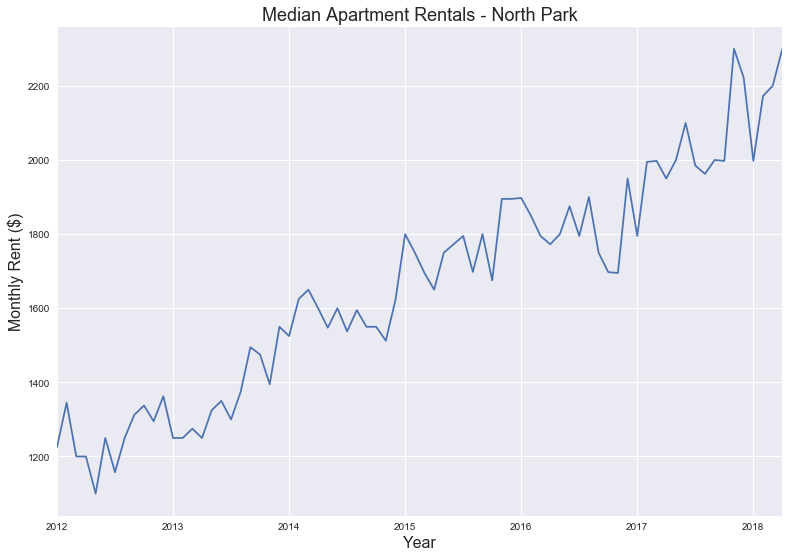

In [13]:
North_Park_melted['RentalPrice'].plot(figsize=(13,9))
plt.title('Median Apartment Rentals - North Park',fontsize=18)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Monthly Rent ($)',fontsize=16)
plt.show()

In [14]:
zhvi_all_homes = pd.read_csv("http://files.zillowstatic.com/research/public/Zip/Zip_Zhvi_AllHomes.csv")

In [15]:
zhvi_all_homes.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,61639,10025,New York,NY,New York,New York,1,171600.0,171600.0,171400.0,...,1094700,1097700,1103400,1119700,1134000,1138100,1134400,1129300,1125200,1125000
1,84654,60657,Chicago,IL,Chicago,Cook,2,158400.0,159700.0,160700.0,...,343800,344500,344100,345000,346500,347200,347500,348300,349400,349300
2,61637,10023,New York,NY,New York,New York,3,347900.0,349600.0,351100.0,...,1608800,1603800,1597900,1593900,1586700,1565700,1542400,1532100,1527700,1518600
3,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,4,235100.0,236300.0,236100.0,...,307200,309100,311700,313400,314300,315500,317100,318600,320100,320900
4,91982,77494,Katy,TX,Houston,Harris,5,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900


In [16]:
len(zhvi_all_homes)

14819

In [17]:
zri_all_homes = pd.read_csv("http://files.zillowstatic.com/research/public/Zip/Zip_Zri_AllHomes.csv")

In [18]:
len(zri_all_homes)

15931

In [19]:
zri_all_homes.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2010-11,2010-12,2011-01,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,61639,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,...,3692,3712,3738,3732,3716,3685,3657,3631,3622,3611
1,84654,60657,Chicago,IL,Chicago,Cook,2,1861.0,1863.0,1861.0,...,2094,2100,2104,2107,2098,2085,2073,2069,2055,2038
2,61637,10023,New York,NY,New York,New York,3,NaN,NaN,NaN,...,4064,4111,4162,4162,4122,4040,3983,3914,3886,3838
3,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,4,1581.0,1583.0,1591.0,...,1938,1939,1940,1940,1939,1936,1929,1924,1922,1919
4,91982,77494,Katy,TX,Houston,Harris,5,2244.0,2247.0,2233.0,...,2234,2234,2235,2235,2234,2238,2249,2261,2271,2271


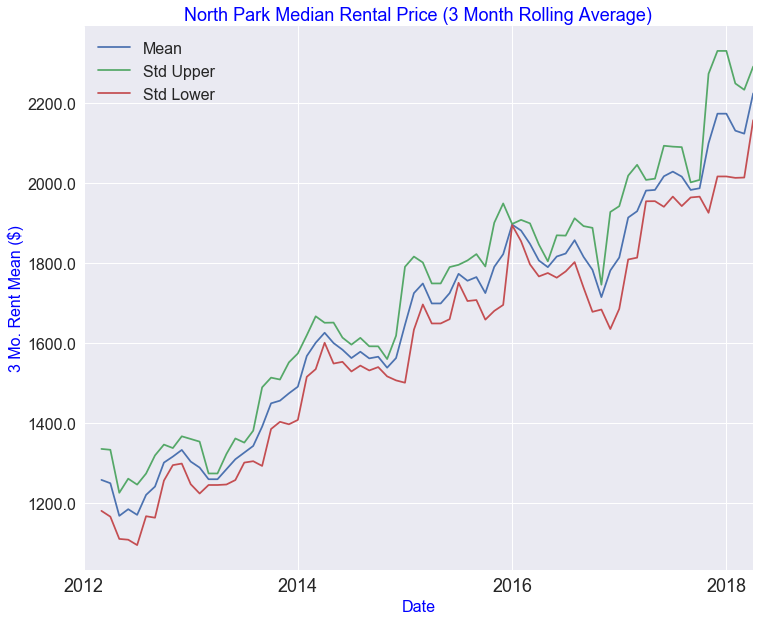

In [20]:
ax = North_Park_melted.rolling(3).mean()['RentalPrice'].plot(figsize=(12,10))

North_Park_melted.rolling(3).std().add(North_Park_melted.rolling(3).mean())['RentalPrice'].plot(ax=ax)

North_Park_melted['RentalPrice'].rolling(3).mean().sub(North_Park_melted['RentalPrice'].rolling(3).std()).plot(ax=ax)

ax.set_xticks(['2012','2014','2016','2018'])
ax.set_xticklabels(['2012','2014','2016','2018'],fontdict={'fontsize':18})
#ax.set_yticks('1200','1400','1600','1800','2000','2200'])
ax.set_yticklabels(ax.get_yticks(),fontdict={'fontsize':16})
ax.set_xlabel('Date',fontsize=16,color='blue')
ax.set_ylabel('3 Mo. Rent Mean ($)',fontsize=16,color='blue')

plt.title('North Park Median Rental Price (3 Month Rolling Average)',fontsize=18,color='blue')
plt.legend(['Mean','Std Upper','Std Lower'],fontsize=16)

plt.show()

- Need to put together a package that allows for selecting the Region Type (e.g. Zip Code, Neighborhood)
- Concatenate dataframes with different rooms, square footage as well. 
- Consider comparing Value vs. Rent, though unclear if it will translate meaningfully. 
- Need to import matplotlib.ticker and format to allow string on the y-axis ($ format)

In [21]:
North_Park_melted['StdLower'] = North_Park_melted['RentalPrice'].rolling(3).mean().sub(North_Park_melted['RentalPrice'].rolling(3).std())
North_Park_melted['StdUpper'] = North_Park_melted['RentalPrice'].rolling(3).mean().add(North_Park_melted['RentalPrice'].rolling(3).std())

In [22]:
North_Park_melted.tail()

,RegionName,City,State,Metro,CountyName,SizeRank,RentalPrice,StdLower,StdUpper
Date,,,,,,,,,
2017-12-01,92104,San Diego,CA,San Diego,San Diego,364,2222.5,2016.204140,2330.462526
2018-01-01,92104,San Diego,CA,San Diego,San Diego,364,1997.5,2016.204140,2330.462526
2018-02-01,92104,San Diego,CA,San Diego,San Diego,364,2172.5,2012.687943,2248.978724
2018-03-01,92104,San Diego,CA,San Diego,San Diego,364,2200.0,2013.494436,2233.172231
2018-04-01,92104,San Diego,CA,San Diego,San Diego,364,2300.0,2157.069101,2291.264232


In [23]:
from statsmodels.graphics import tsaplots

C:\Users\mgavin\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


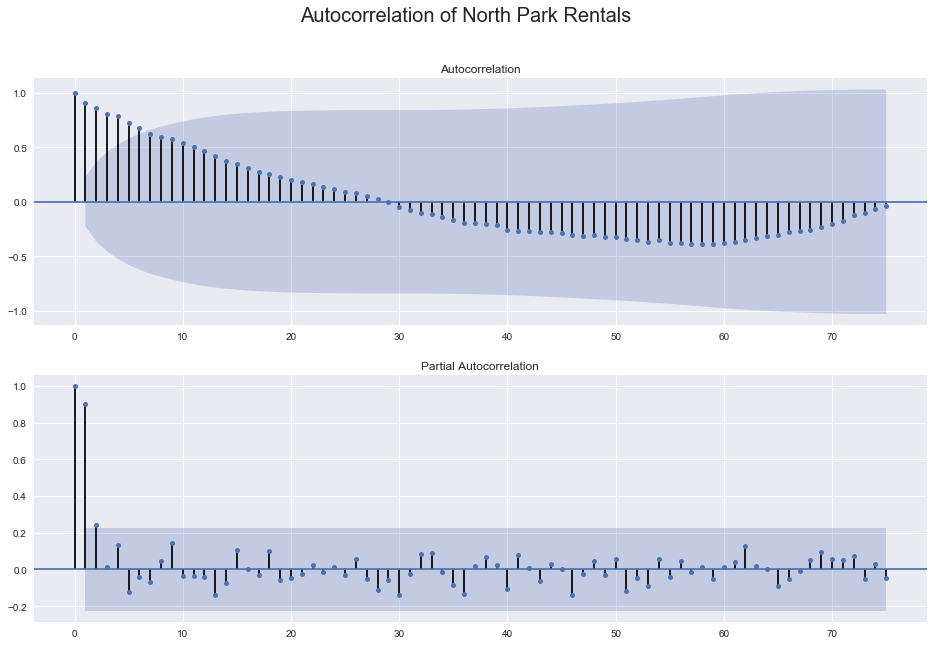

In [24]:
fig, axes = plt.subplots(2,1,figsize=(16,10))

fig.suptitle('Autocorrelation of North Park Rentals',fontsize=20)

tsaplots.plot_acf(North_Park_melted['RentalPrice'],ax=axes[0])

tsaplots.plot_pacf(North_Park_melted['RentalPrice'],ax=axes[1])

plt.show()

### Autocorrelation ###

#### Measures the relation between time point t and previous time points (e.g. t-3) ####

- Based on the ACF graph, there appears to be a correlation between lags 1 through 6
- The PACF graph shows a drop-off, but lag 3 is still significant, which could indicate quarterly trends
- Next is to determine whether there is any seasonality underlying the general upward trend, or if it is mostly noise

In [25]:
def seasonality_monthly(df_input,sampling='M',window='quarterly'):
    

    window_dict = {'quarterly':3,
                   'semiannual':6,
                   'yearly':12}

    quarterly_trends = []
    
    w = window_dict.get(window)

    for i in range(w):
    
        df = pd.DataFrame()
        
        quarterly_trends.append(df.append(df_input.iloc[i::w]))
        
    return quarterly_trends

In [26]:
quarterly_list = seasonality_monthly(North_Park_melted)

In [27]:
quarterly_list

[            RegionName       City State      Metro CountyName  SizeRank  \
 Date                                                                      
 2012-01-01       92104  San Diego    CA  San Diego  San Diego       364   
 2012-04-01       92104  San Diego    CA  San Diego  San Diego       364   
 2012-07-01       92104  San Diego    CA  San Diego  San Diego       364   
 2012-10-01       92104  San Diego    CA  San Diego  San Diego       364   
 2013-01-01       92104  San Diego    CA  San Diego  San Diego       364   
 2013-04-01       92104  San Diego    CA  San Diego  San Diego       364   
 2013-07-01       92104  San Diego    CA  San Diego  San Diego       364   
 2013-10-01       92104  San Diego    CA  San Diego  San Diego       364   
 2014-01-01       92104  San Diego    CA  San Diego  San Diego       364   
 2014-04-01       92104  San Diego    CA  San Diego  San Diego       364   
 2014-07-01       92104  San Diego    CA  San Diego  San Diego       364   
 2014-10-01 

In [28]:
annual_groupings = North_Park_melted.select_dtypes(include=['number']).groupby(North_Park_melted.index.year).mean()

In [29]:
annual_groupings.index = pd.to_datetime(annual_groupings.index,format='%Y')

In [30]:
annual_groupings = annual_groupings.resample('MS',convention='start').ffill()
annual_groupings.head()

,RegionName,SizeRank,RentalPrice,StdLower,StdUpper
Date,,,,,
2012-01-01,92104,364,1252.916667,1182.703933,1303.296067
2012-02-01,92104,364,1252.916667,1182.703933,1303.296067
2012-03-01,92104,364,1252.916667,1182.703933,1303.296067
2012-04-01,92104,364,1252.916667,1182.703933,1303.296067
2012-05-01,92104,364,1252.916667,1182.703933,1303.296067


In [31]:
seasonal_df = pd.concat(quarterly_list,ignore_index=False)

In [32]:
seasonal_df = seasonal_df.sort_index()

In [33]:
seasonal_df = seasonal_df.join(annual_groupings.loc[:,['RentalPrice','StdLower','StdUpper']],lsuffix='_m',rsuffix='_y')

In [34]:
seasonal_df.head()

,RegionName,City,State,Metro,CountyName,SizeRank,RentalPrice_m,StdLower_m,StdUpper_m,RentalPrice_y,StdLower_y,StdUpper_y
Date,,,,,,,,,,,,
2012-01-01,92104,San Diego,CA,San Diego,San Diego,364,1225.0,NaN,NaN,1252.916667,1182.703933,1303.296067
2012-02-01,92104,San Diego,CA,San Diego,San Diego,364,1345.0,NaN,NaN,1252.916667,1182.703933,1303.296067
2012-03-01,92104,San Diego,CA,San Diego,San Diego,364,1200.0,1179.153227,1334.180106,1252.916667,1182.703933,1303.296067
2012-04-01,92104,San Diego,CA,San Diego,San Diego,364,1200.0,1164.617544,1332.049122,1252.916667,1182.703933,1303.296067
2012-05-01,92104,San Diego,CA,San Diego,San Diego,364,1100.0,1108.931640,1224.401694,1252.916667,1182.703933,1303.296067


In [35]:
seasonal_df = seasonal_df.iloc[:,6:]

In [36]:
seasonal_df['RentalPrice_my'] = seasonal_df['RentalPrice_m'] / seasonal_df['RentalPrice_y']
seasonal_df['StdLower_my'] = seasonal_df['StdLower_m'] / seasonal_df['StdLower_y']
seasonal_df['StdUpper_my'] = seasonal_df['StdUpper_m'] / seasonal_df['StdUpper_y']

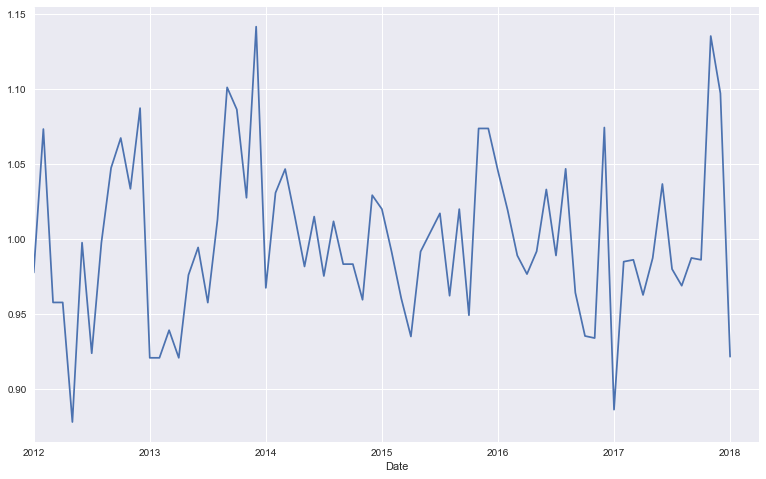

In [37]:
seasonal_df.iloc[:,-3].plot(figsize=(13,8))
plt.show()

In [38]:
quarter_list = []

for index, row in seasonal_df.iterrows():
    
    if index.month in [1,4,7,10]:
        quarter_list.append(1)
        
    elif index.month in [2,5,8,11]:
        quarter_list.append(2)

    else:
        quarter_list.append(3)

        
seasonal_df['QuarterlyGroup'] = quarter_list


In [39]:
seasonal_df.head()

,RentalPrice_m,StdLower_m,StdUpper_m,RentalPrice_y,StdLower_y,StdUpper_y,RentalPrice_my,StdLower_my,StdUpper_my,QuarterlyGroup
Date,,,,,,,,,,
2012-01-01,1225.0,NaN,NaN,1252.916667,1182.703933,1303.296067,0.977719,NaN,NaN,1
2012-02-01,1345.0,NaN,NaN,1252.916667,1182.703933,1303.296067,1.073495,NaN,NaN,2
2012-03-01,1200.0,1179.153227,1334.180106,1252.916667,1182.703933,1303.296067,0.957765,0.996998,1.023697,3
2012-04-01,1200.0,1164.617544,1332.049122,1252.916667,1182.703933,1303.296067,0.957765,0.984708,1.022062,1
2012-05-01,1100.0,1108.931640,1224.401694,1252.916667,1182.703933,1303.296067,0.877951,0.937624,0.939466,2


In [40]:
seasonal_grouped = seasonal_df.groupby(seasonal_df.index.month).mean()

In [41]:
seasonal_grouped.index = pd.to_datetime(seasonal_grouped.index,format='%m').to_period()

seasonal_grouped.head()

,RentalPrice_m,StdLower_m,StdUpper_m,RentalPrice_y,StdLower_y,StdUpper_y,RentalPrice_my,StdLower_my,StdUpper_my,QuarterlyGroup
Date,,,,,,,,,,
1900-01,1641.428571,1624.672948,1815.327052,1708.428571,1627.558801,1763.528501,0.962777,0.954071,0.985323,1
1900-02,1712.500000,1674.169281,1826.941831,1631.916667,1557.174617,1678.121680,1.003555,0.982999,0.993579,2
1900-03,1687.500000,1610.769920,1750.182461,1631.916667,1557.174617,1678.121680,0.979939,0.991431,0.994010,3
1900-04,1674.642857,1647.700241,1735.394997,1631.916667,1557.174617,1678.121680,0.961358,1.001292,0.979483,1
1900-05,1587.083333,1546.513822,1626.541734,1631.916667,1557.174617,1678.121680,0.967797,0.988746,0.968108,2


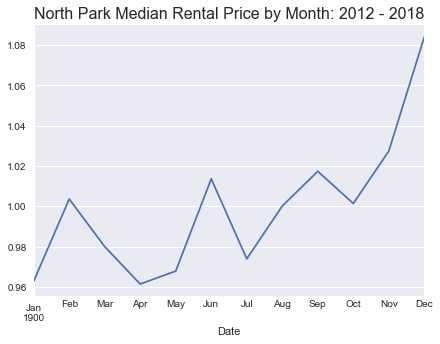

In [42]:
seasonal_grouped['RentalPrice_my'].plot(figsize=(7,5))
plt.title('North Park Median Rental Price by Month: 2012 - 2018',fontsize=16)
plt.show()

- Conclusion from a basic average by month is that rent peaks in December and again in June, for summer rentals

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [44]:
decomposed_df = seasonal_decompose(seasonal_df.iloc[:,0])

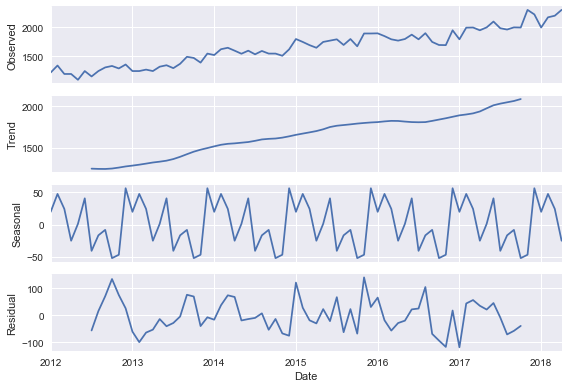

In [45]:
decomposed_df.plot()

- More complicated seasonality emerges here, showing a much lower dip in early fall/October area
- A lot of activity on the residual plot hints that randomness is prevalent

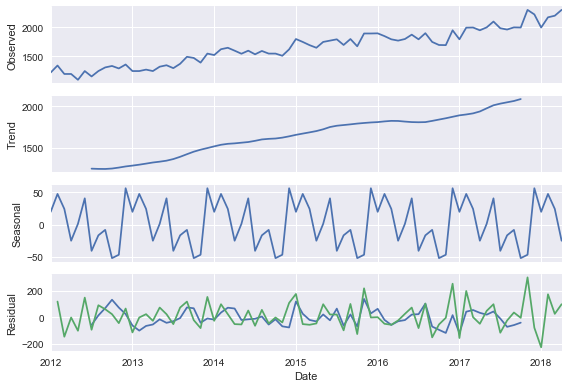

In [46]:
stationary_df = seasonal_df['RentalPrice_m']

#stationary_df = stationary_df.apply(np.log)
stationary_df = stationary_df - stationary_df.shift()
stationary_df.dropna(inplace=True)
stationary_df.plot()

plt.show()

## Testing Stationarity

In [47]:
from statsmodels.tsa.stattools import adfuller

In [48]:
 def test_stationarity(df, print_results=True, **kwargs):
    
    '''Use stattools adfuller function with a more DataFrame-friendly format
    
    df = pandas.DataFrame or pandas.Series: required, used for testing stationarity
    
    **kwargs = dict, used to feed adfuller arguments'''

    raw_results = adfuller(df,**kwargs)
    
    df_rows = {fk: fv for fv, fk in zip(raw_results[:4],list(['Test Statistic','P-Value','Lags Used','Observations Taken']))}
    
    df_rows.update({sk: sv for sk, sv in raw_results[4:-1][0].items()})
    
    
    dickey_test_results = pd.DataFrame(index=df_rows.keys(),data=list(df_rows.values()),columns=['Metric'])
    
    if print_results:
        print('Results of the Augmented Dickey-Fuller Test: \n\n', dickey_test_results.head(10))
    
    return dickey_test_results

In [49]:
dickey_df = test_stationarity(stationary_df,autolag='AIC')

Results of the Augmented Dickey-Fuller Test: 

                        Metric
Test Statistic      -4.316248
P-Value              0.000416
Lags Used            7.000000
Observations Taken  67.000000
1%                  -3.531955
5%                  -2.905755
10%                 -2.590357


### Fortunately, Differencing induced Stationarity

In [50]:
nonstationary_df = seasonal_df['RentalPrice_m']

In [51]:
dickey_df_2 = test_stationarity(nonstationary_df,autolag='AIC')

Results of the Augmented Dickey-Fuller Test: 

                        Metric
Test Statistic       0.321271
P-Value              0.978300
Lags Used            8.000000
Observations Taken  67.000000
1%                  -3.531955
5%                  -2.905755
10%                 -2.590357


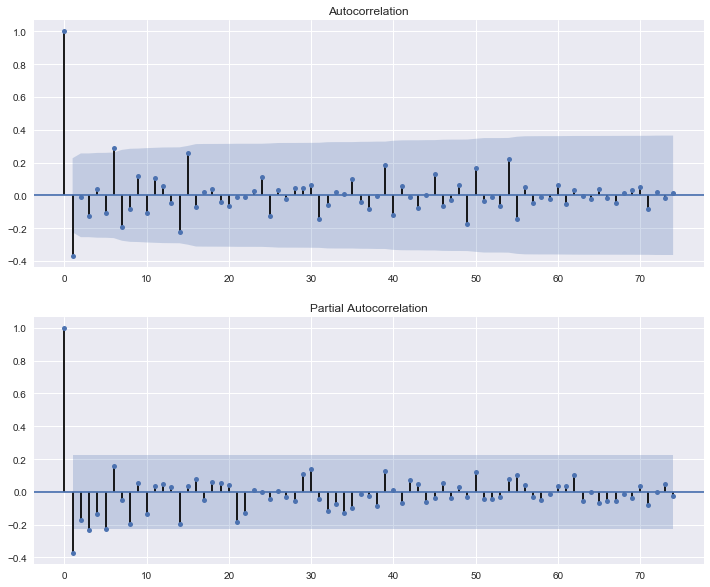

In [52]:
fig, axes = plt.subplots(2,1,figsize=(12,10))

tsaplots.plot_acf(stationary_df,ax=axes[0])
tsaplots.plot_pacf(stationary_df,ax=axes[1])

plt.show()

#### Looks like an AR(1) process at work ###

#### Time to check out the ARIMA model and see if the correlation (roughly -.4) can help us predict future values

In [53]:
new_df = np.cumsum(stationary_df) + seasonal_df.loc[seasonal_df.index.min(),'RentalPrice_m']

In [54]:
from time_series.analysis import *

In [55]:
df, corr = compute_correlation(stationary_df.values,stationary_df.shift(-3))

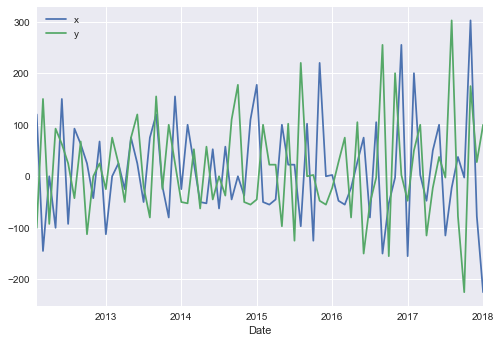

In [56]:
df.iloc[:,:2].plot()
plt.show()

In [57]:
df, corr = autocorrelate(stationary_df)

In [58]:
autocorrelations = []
lengths = []

for i in range(0,21):
    
    df, corr = autocorrelate(stationary_df,shift=i)
    
    autocorrelations.append(corr)
    lengths.append(len(df))

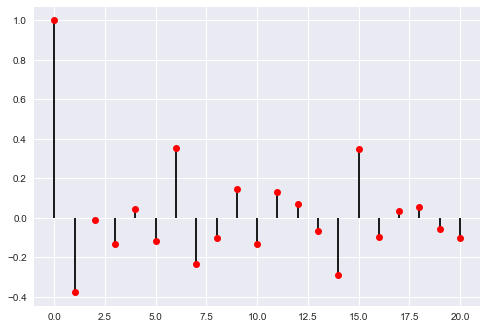

In [59]:
plt.plot(autocorrelations,linestyle='none',marker='o',color='red')

for i, x in enumerate(autocorrelations):
    plt.vlines(x=i,ymin=min(0,x),ymax=max(0,x))

plt.show()

### Voila! A custom Autocorrelation function that resembles statsmodels acf function:

##### Important difference: It appears that the Pearson R is not the basis for acf, but rather np.correlate, hence varying results after lag 1

#### Next: need to consider error bars as part of autocorrelate function

In [60]:
df_5, corr_5 = autocorrelate(stationary_df,shift=5)

In [61]:
autocorrelations

[1.0,
 -0.3757553483848617,
 -0.010108666380579032,
 -0.1318775729801633,
 0.045458539146505716,
 -0.1189720623179936,
 0.35569870613530913,
 -0.23526388130003428,
 -0.10268225609475595,
 0.14869769643719563,
 -0.13173934032052678,
 0.13142148328840753,
 0.07117265097721702,
 -0.06385117466538907,
 -0.28777626797085204,
 0.3485799167572358,
 -0.09396146427190383,
 0.0346498907777995,
 0.05733096110554089,
 -0.0574698753538752,
 -0.10367156328747637]

In [62]:
from statsmodels.tsa.stattools import acf, acovf

KeyError: 'RentalPrice_m'